<h1>Udacity Self-Driving Car Nanodegree Program</h1>


<h2>Advanced Lane Finding Project</h2>
    
<b>The steps of this project are the following::</b>

<ol>
    <li>Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.</li>
    <li>Apply a distortion correction to raw images.</li>
    <li>Use color transforms, gradients, etc., to create a thresholded binary image.</li>
    <li>Apply a perspective transform to binary image ("birds-eye view").</li>
    <li>Detect lane pixels and fit to find the lane boundary.</li>
    <li>Determine the curvature of the lane and vehicle position with respect to center.</li>
    <li>Warp the detected lane boundaries back onto the original image.</li>
    <li>Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.</li>
</ol>

In [1]:
# import all needed libraries
import numpy as np 
import cv2 
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

<h3>Camera Calibration and Undistortion of Images</h3>

In [29]:
nx = 9
ny = 6
img_dir_path = './camera_cal/calibration*.jpg'

def find_img_obj_points():
    # 1. Prepare object points like (0,0,0), (1,0,0), ..., (8,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x,y coordinates 

    # 2. Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    img_size = []
    
    # 3. Make a list of calibration images
    images = glob.glob(img_dir_path)
    
    # 4. Create a figure for plotting imgs
    f, axes = plt.subplots(1,2,figsize=(30,30))
    
    # 5. Step through the list and search for chessboard corners
    for i, fname in enumerate(images):
        origin_img = cv2.imread(fname)
        if i==2: 
            img_size.append((origin_img.shape[0],origin_img.shape[1]))
            # Plotting the original Image
            axes[0].set_title('Original Image', fontsize=20)
            axes[0].imshow(origin_img)
        gray = cv2.cvtColor(origin_img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners in distorted img
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(origin_img, (nx,ny), corners, ret)
            if i==2: 
                # Plotting original Image with Chessboard Corners
                axes[1].set_title('Image with Chessboard Corners', fontsize=20)
                axes[1].imshow(origin_img)
        
    return objpoints, imgpoints, img_size[0]

In [35]:
def calc_calibration_params():
    """Calculate and return camera matrix and distortion coefficients."""
    obj_points, img_points, img_shape = find_img_obj_points()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_shape, None, None)
    return mtx, dist

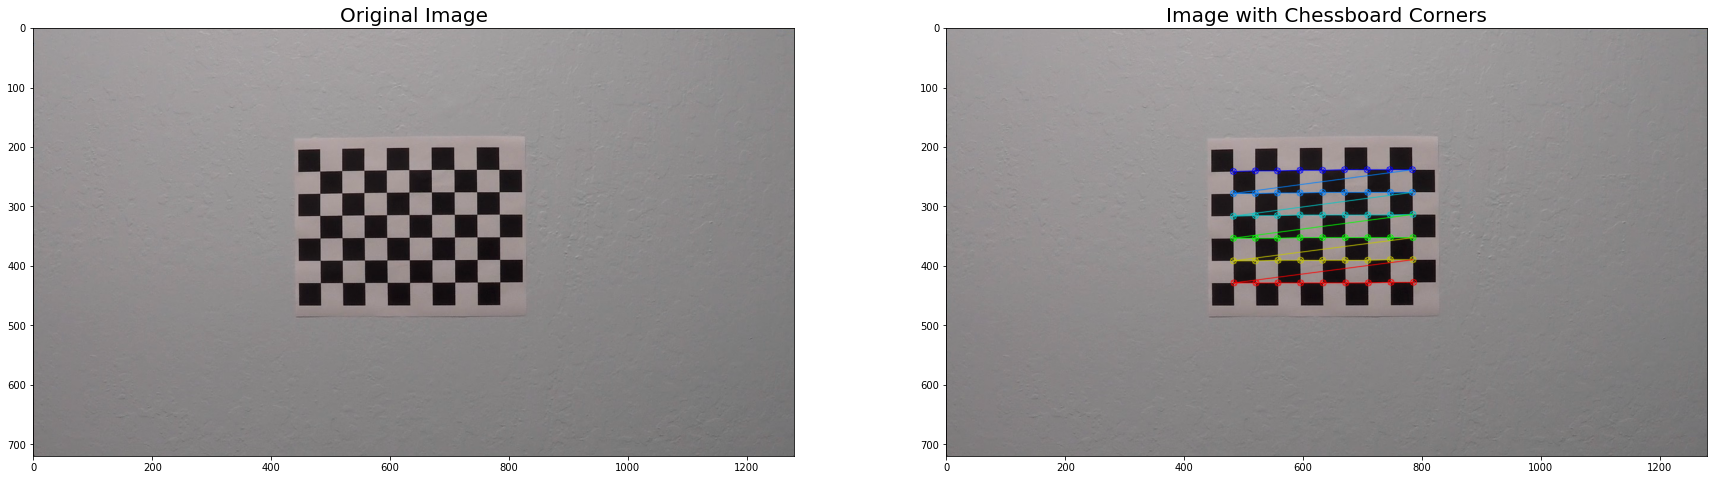

In [36]:
x,y = calc_calibration_params()

In [37]:
def undistort_image(image):

    mtx, dist = calc_calibration_params()
    dst_img = cv2.undistort(image, mtx, dist, None, mtx)
    return dst_img

<h3>Create thresholded binary Image </h3>

In [55]:
# function to return thresholded gradient based binary output 
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)): 
    # 1. Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2. Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x': 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else: 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3. Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4. Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(abs_sobel * 255 / np.max(abs_sobel))
    
    # 5. Threshold the scaled_sobel and create a binary output
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

In [56]:
# function to return magnitute of derivatives thresholded binary output
def mag_thresh(img, sobel_kernel=3, thresh=(0,255)): 
    # 1. Convert to grayscale 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2. Take the gradient in x and y separately 
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3. Calculate the magnitude
    magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    
    # 4. Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_mag = np.uint8(magnitude * 255 / np.max(magnitude))
    
    # 5. Create a binary mask where magnitude thresholds are met 
    binary_output = np.like_zeros(scaled_mag)
    binary_output[(scaled_mag > thresh[0]) & (scaled_mag <= thresh[1])] = 1
    
    return binary_output

In [57]:
# function to return direction of derivatives thresholded binary output
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)

    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(gray)
    binary_output[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1

    return binary_output

<h3>Perspective Transform</h3> 